In [1]:
import torch
import torchvision

In [2]:
# 数据处理
!pip install --upgrade seaborn

In [3]:
import numpy as np,pandas as pd 
from glob import glob
import shutil ,os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [4]:
dim = 512 #初始图片数据尺寸
fold = 4     #分为四则

In [5]:
train_df = pd.read_csv('/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit/Train.csv')
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [6]:
#将图片路径整合到表中
train_df['image_path'] = f'/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit/Train_Images/Train_Images/'+train_df.Image_ID+'.jpg'
train_df.head()

,Image_ID,class,xmin,ymin,width,height,image_path
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...


In [7]:
cls = train_df['class'].unique()
cls

array(['fruit_woodiness', 'fruit_brownspot', 'fruit_healthy'],
      dtype=object)

In [8]:
def setCategory(c):
    if c["class"] == 'fruit_woodiness':
        return 0
    elif c['class']== 'fruit_brownspot':
        return 1
    elif c['class'] == 'fruit_healthy':
        return 2
    else: 
        return -1

In [9]:
train_df['class_id'] = train_df.apply(setCategory,axis=1)
train_df.head()

,Image_ID,class,xmin,ymin,width,height,image_path,class_id
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1


In [10]:
train_df['class_id'].unique()

array([0, 1, 2])

In [11]:
#整合图片size
import cv2
def setImageSize(row):
        #读取图片
    img = cv2.imread(f"{row.image_path}")
#     print(img.shape)
    hig, wid,_ = img.shape
    row['img_hig']=hig
    row['img_wid']=wid
    return row
#     print(hig,wid)

In [12]:
# setImageSize(train_df.loc[0])
train_df = train_df.apply(setImageSize,axis=1)

In [13]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height,image_path,class_id,img_hig,img_wid
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0,512,512
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512


In [14]:
#将box按比例压缩
train_df['box_xmin'] = train_df.apply(lambda row: (row.xmin)/row.img_wid,axis=1)
train_df['box_ymin'] = train_df.apply(lambda row: (row.ymin)/row.img_hig,axis=1)

train_df['box_xmax'] = train_df.apply(lambda row: (row.xmin+row.width)/row.img_wid,axis=1)
train_df['box_ymax'] = train_df.apply(lambda row: (row.ymin+row.height)/row.img_hig,axis=1)

In [15]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height,image_path,class_id,img_hig,img_wid,box_xmin,box_ymin,box_xmax,box_ymax
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0,512,512,0.169922,0.170898,0.615234,0.778320
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.190430,0.034180,0.668945,0.726562
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.305664,0.409180,0.790039,1.000000
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.244141,0.376953,0.741211,0.800781
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.155273,0.454102,0.611328,0.809570


In [16]:
train_df = train_df.rename(columns={'class':'class_name'})
train_df.head()

,Image_ID,class_name,xmin,ymin,width,height,image_path,class_id,img_hig,img_wid,box_xmin,box_ymin,box_xmax,box_ymax
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0,512,512,0.169922,0.170898,0.615234,0.778320
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.190430,0.034180,0.668945,0.726562
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.305664,0.409180,0.790039,1.000000
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.244141,0.376953,0.741211,0.800781
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.155273,0.454102,0.611328,0.809570


In [17]:
train_df.image_path[0]
train_df.box_xmin[0]

0.169921875

87.0 87.5 315.0 398.5


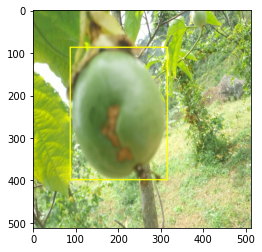

In [18]:
from PIL import Image
# image = cv2.imread(train_df.image_path[0])
img = cv2.cvtColor(cv2.imread(train_df.image_path[0]),cv2.COLOR_BGR2RGB)
xmin = train_df.box_xmin[0]*train_df.img_wid[0]
ymin = train_df.box_ymin[0]*train_df.img_hig[0]
xmax = train_df.box_xmax[0]*train_df.img_wid[0]
ymax = train_df.box_ymax[0]*train_df.img_hig[0]
print(xmin,ymin,xmax,ymax)

cv2.rectangle(img,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(255,255,0),2)
# pan = np.array(Image.open(train_df.image_path[0]))
# cv2.imshow('head', img)
plt.imshow(img)

In [19]:
train_df['box_xmid'] = train_df.apply(lambda row: (row.box_xmin+row.box_xmax)/2,axis=1)
train_df['box_ymid'] = train_df.apply(lambda row: (row.box_ymin+row.box_ymax)/2,axis=1)

train_df['w']= train_df.apply(lambda row: (row.box_xmax-row.box_xmin),axis=1)
train_df['h']= train_df.apply(lambda row: (row.box_ymax-row.box_ymin),axis=1)

train_df['area']= train_df['w']*train_df['h']
train_df.head()

,Image_ID,class_name,xmin,ymin,width,height,image_path,class_id,img_hig,img_wid,box_xmin,box_ymin,box_xmax,box_ymax,box_xmid,box_ymid,w,h,area
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0,512,512,0.169922,0.170898,0.615234,0.778320,0.392578,0.474609,0.445312,0.607422,0.270493
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.190430,0.034180,0.668945,0.726562,0.429688,0.380371,0.478516,0.692383,0.331316
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.305664,0.409180,0.790039,1.000000,0.547852,0.704590,0.484375,0.590820,0.286179
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.244141,0.376953,0.741211,0.800781,0.492676,0.588867,0.497070,0.423828,0.210672
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.155273,0.454102,0.611328,0.809570,0.383301,0.631836,0.456055,0.355469,0.162113


In [21]:
features = ['box_xmin','box_ymin','box_xmax','box_ymax','box_xmid','box_ymid','w','h','area']
X = train_df[features]
y = train_df['class_id']
X.shape , y.shape

((3906, 9), (3906,))

In [22]:
train_df = train_df.rename(columns={'class':'class_name'})
train_df.head()

,Image_ID,class_name,xmin,ymin,width,height,image_path,class_id,img_hig,img_wid,box_xmin,box_ymin,box_xmax,box_ymax,box_xmid,box_ymid,w,h,area
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0,512,512,0.169922,0.170898,0.615234,0.778320,0.392578,0.474609,0.445312,0.607422,0.270493
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.190430,0.034180,0.668945,0.726562,0.429688,0.380371,0.478516,0.692383,0.331316
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.305664,0.409180,0.790039,1.000000,0.547852,0.704590,0.484375,0.590820,0.286179
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.244141,0.376953,0.741211,0.800781,0.492676,0.588867,0.497070,0.423828,0.210672
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.155273,0.454102,0.611328,0.809570,0.383301,0.631836,0.456055,0.355469,0.162113


In [23]:
class_ids ,class_names = list(zip(*set(zip(train_df.class_id,train_df.class_name))))
classes = list((np.array(class_names)[np.argsort(class_ids)]))
classes = list(map(lambda x :str(x),classes))
classes

['fruit_woodiness', 'fruit_brownspot', 'fruit_healthy']

In [24]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=40 ,random_state=1,n_iter=5000)
data_X = X
data_y = y.loc[data_X.index]
embs = tsne.fit_transform(data_X)
#增加置信度
plot_x = embs[:,0]
plot_y = embs[:,1]

CPU times: user 2min 7s, sys: 71.4 ms, total: 2min 7s
Wall time: 2min 7s


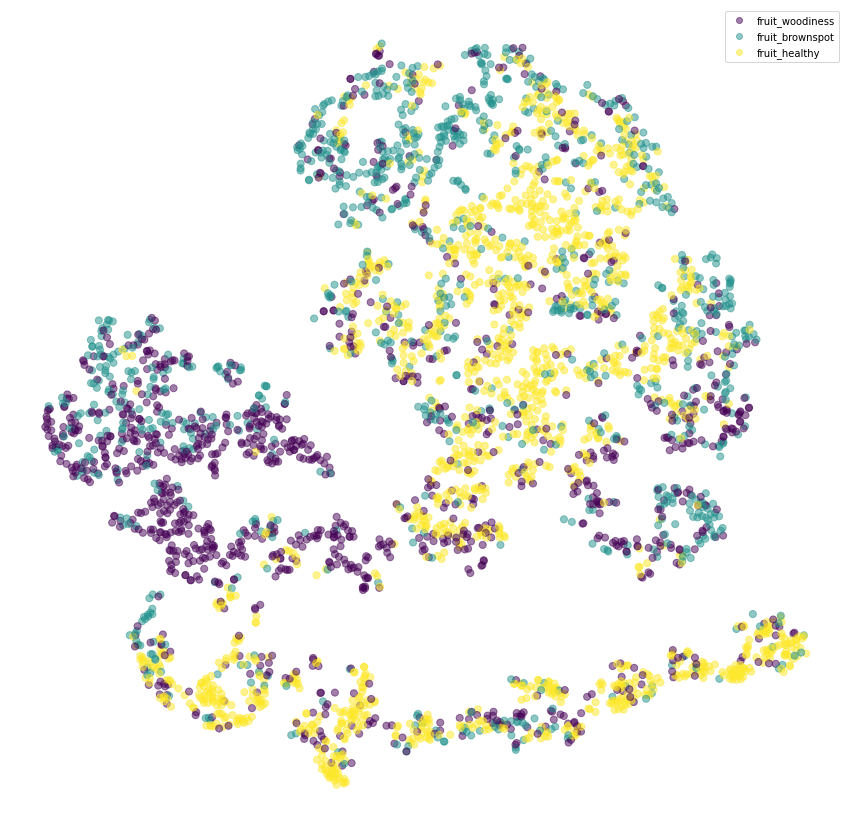

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.axis('off')
scatter = plt.scatter(plot_x,plot_y,marker='o',s=50,c=data_y.to_list(),alpha=0.5,cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],labels=classes)

## BBOX Location

### x_mid 和y_mid

[0.39257812 0.4296875  0.54785156 ... 0.83056641 0.46142578 0.43408203]
[0.47460938 0.38037109 0.70458984 ... 0.56152344 0.47216797 0.57666016]


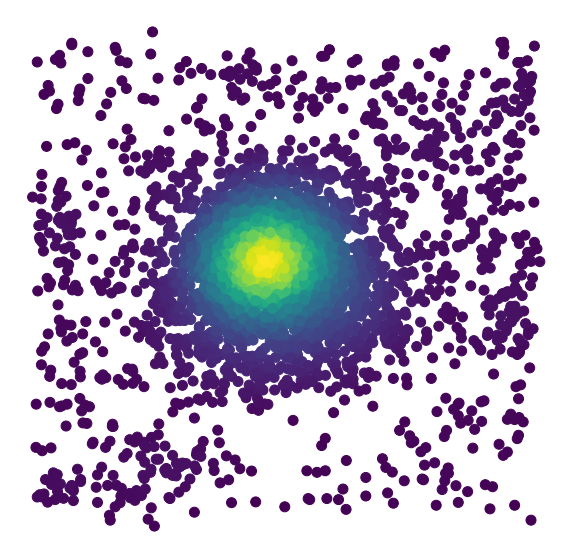

In [26]:
from scipy.stats import gaussian_kde

x_val = train_df.box_xmid.values     #第一维数据
y_val = train_df.box_ymid.values     #第二维数据
print(x_val)
print(y_val)
#计算点密度
xy = np.vstack([x_val,y_val])    #将两维数据进行叠加
kenal = gaussian_kde(xy)        #根据xy的样本数据，在定义域上建立概率密度分布，kenal 其实就是一个概率密度分布函数，输入xy坐标给出相应的概率密度
z = kenal.evaluate(xy)          #得到每个样本点的概率密度

# z = gaussian_kde(xy)(xy)     #上面两行的简化版

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.scatter(x_val,y_val,c=z,s=100,cmap='viridis')
plt.show()

## bbx_w 和 bbox_h 概率密度分布

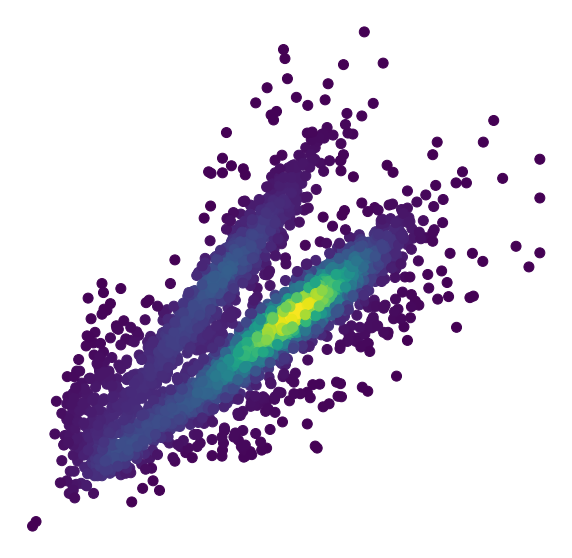

In [27]:
x_val = train_df.w.values
y_val = train_df.h.values

#计算概率密度
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig ,ax = plt.subplots(figsize = (10,10))
ax.axis('off')
ax.scatter(x_val,y_val,c=z,s=100,cmap='viridis')
plt.show()

### 图片大小分布

In [28]:
#两个向量不能相同
x_val = train_df.img_wid.values
y_val = train_df.img_hig.values

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('image_width')
# ax.set_ylabel('image_height')
plt.show()

LinAlgError: singular matrix

In [29]:
#划分数据集, 多则训练
gkf = GroupKFold(n_splits=5)
train_df['fold'] = -1
for fold,(train_idx,val_idx) in enumerate(gkf.split(train_df,groups=train_df.Image_ID.tolist())):
    train_df.loc[val_idx,'fold'] = fold
train_df.head()

,Image_ID,class_name,xmin,ymin,width,height,image_path,class_id,img_hig,img_wid,box_xmin,box_ymin,box_xmax,box_ymax,box_xmid,box_ymid,w,h,area,fold
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0,512,512,0.169922,0.170898,0.615234,0.778320,0.392578,0.474609,0.445312,0.607422,0.270493,0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.190430,0.034180,0.668945,0.726562,0.429688,0.380371,0.478516,0.692383,0.331316,4
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.305664,0.409180,0.790039,1.000000,0.547852,0.704590,0.484375,0.590820,0.286179,1
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.244141,0.376953,0.741211,0.800781,0.492676,0.588867,0.497070,0.423828,0.210672,3
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.155273,0.454102,0.611328,0.809570,0.383301,0.631836,0.456055,0.355469,0.162113,1


In [31]:
train_files = []
val_files = []
# val_files += [list(train_df[train_df.fold==fold].image_path.unique()),list(train_df[train_df.fold==fold].box_xmin),list(train_df[train_df.fold==fold].class_id),list(train_df[train_df.fold==fold].box_ymin),list(train_df[train_df.fold==fold].box_xmax),list(train_df[train_df.fold==fold].box_ymax)]
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files),len(val_files)

(2401, 600)

In [32]:
train_df[train_df.fold==fold]

,Image_ID,class_name,xmin,ymin,width,height,image_path,class_id,img_hig,img_wid,box_xmin,box_ymin,box_xmax,box_ymax,box_xmid,box_ymid,w,h,area,fold
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.190430,0.034180,0.668945,0.726562,0.429688,0.380371,0.478516,0.692383,0.331316,4
16,ID_05V8XX4L,fruit_woodiness,286.5,150.5,162.0,193.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0,512,512,0.559570,0.293945,0.875977,0.671875,0.717773,0.482910,0.316406,0.377930,0.119579,4
17,ID_05V8XX4L,fruit_woodiness,112.0,118.0,155.5,184.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,0,512,512,0.218750,0.230469,0.522461,0.589844,0.370605,0.410156,0.303711,0.359375,0.109146,4
26,ID_07MFGPW3,fruit_healthy,141.0,189.5,244.5,197.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.275391,0.370117,0.752930,0.755859,0.514160,0.562988,0.477539,0.385742,0.184207,4
27,ID_07MFGPW3,fruit_healthy,4.5,233.0,81.5,58.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.008789,0.455078,0.167969,0.568359,0.088379,0.511719,0.159180,0.113281,0.018032,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,ID_ZZ0MWI19,fruit_brownspot,90.5,18.5,327.0,267.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,1,512,512,0.176758,0.036133,0.815430,0.557617,0.496094,0.296875,0.638672,0.521484,0.333057,4
3901,ID_ZZAB1FH1,fruit_healthy,96.0,175.5,289.5,222.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.187500,0.342773,0.752930,0.776367,0.470215,0.559570,0.565430,0.433594,0.245167,4
3902,ID_ZZAB1FH1,fruit_healthy,330.0,241.0,182.0,180.5,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.644531,0.470703,1.000000,0.823242,0.822266,0.646973,0.355469,0.352539,0.125317,4
3903,ID_ZZJZ2CV6,fruit_healthy,358.0,234.0,134.5,107.0,/home/snnu/chenkequan/paperExper/yolov5/dataSe...,2,512,512,0.699219,0.457031,0.961914,0.666016,0.830566,0.561523,0.262695,0.208984,0.054899,4


### 复制文件，整理数据集

In [39]:
os.makedirs('/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5/labels/train',exist_ok=True)
os.makedirs('/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5/labels/val',exist_ok=True)
os.makedirs('/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5/images/train',exist_ok=True)
os.makedirs('/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5/images/val',exist_ok=True)

labeldir = '/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit/labels/train/'
#当前没有源标签，由自己后面生成，当前
for file in tqdm(train_files):
    shutil.copy(file,'/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5/images/train')
    filename = file.split("/")[-1].split('.')[0]
    shutil.copy(os.path.join(labeldir,filename+'.txt'),'/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file,'/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5/images/val')
    filename = file.split("/")[-1].split('.')[0]
    shutil.copy(os.path.join(labeldir,filename+'.txt'),'/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5/labels/val')        
        


  0%|          | 0/2401 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [42]:
## 获取类名
class_ids,class_names ,classes

((2, 1, 0),
 ('fruit_healthy', 'fruit_brownspot', 'fruit_woodiness'),
 ['fruit_woodiness', 'fruit_brownspot', 'fruit_healthy'])

## Yolov5

In [ ]:
from os import listdir
from os.path import isfile,jion
import yaml

cwd = '/home/snnu/chenkequan/paperExper/yolov5/dataSet/fruit_yolov5'
